## EDA
First I will conduct exploratory data analysis to see how the data looks like and how we should approach modelling it.

In [1]:
#import dependencies 

import pandas as pd
import numpy as np
import sqlite3 as sql3

In [2]:
#master query
MASTER_QUERY = 'SELECT * FROM sqlite_master'

# examine tables within the provided database
con = sql3.connect('data/data.db')
cursor = con.cursor()
cursor.execute(MASTER_QUERY)
cursor.fetchall()

[('table',
  'homes',
  'homes',
  2,
  'CREATE TABLE "homes" (\n"id" TEXT,\n  "multiple_occupancy" INTEGER\n)'),
 ('table',
  'motion',
  'motion',
  5,
  'CREATE TABLE "motion" (\n"id" TEXT,\n  "home_id" TEXT,\n  "datetime" TEXT,\n  "location" TEXT\n)')]

There are two data tables present in the the database, homes table (with two schemas) and motion database (with five schemas). Homes contains our target variable, Motion - raw data we can use for modelling.

In [3]:
# write SQL queries
HOME_QUERY = "SELECT * from homes"
MOTION_QUERY = "SELECT * from motion"

# get data
homes_df = pd.read_sql_query(HOME_QUERY, con)
motion_df = pd.read_sql_query(MOTION_QUERY, con)

### home_df

In [4]:
#visualise
homes_df.head()

,id,multiple_occupancy
0,dc922bd9bf8a2a9437642fe0dce9dcaa,0
1,d40fc88629271da7b5833ed3f3222d17,1
2,3fb064da180f02862063eca8e3b609c0,1
3,16d71b9c46d9abd765bf395818efe527,0
4,458264665736fd26184a8ea5641e6c48,1


In [5]:
#info on missingness
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  106 non-null    object
 1   multiple_occupancy  106 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [6]:
#describe dataset 
homes_df.describe(include='all')

,id,multiple_occupancy
count,106,106.000000
unique,106,NaN
top,dc922bd9bf8a2a9437642fe0dce9dcaa,NaN
freq,1,NaN
mean,NaN,0.575472
std,NaN,0.496619
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [7]:
#count no. single & multiple occupied households
homes_df.groupby('multiple_occupancy').count()

,id
multiple_occupancy,
0,45
1,61


Mutliple occupancy is our target variable so it's a binary classification; each id represents a sample we use for modelling. No obvious missingness/nans. There is more multiple occupancy households than single occupancy households so stratification will be needed when splitting into train-test.

There is also not much data - while 106 should be enough for a simple model, after splitting it into train & test set we will have not even 100 samples per development set, not giving us enough confidence in our model's performance. We should seek more data if possible.

### motion_df

In [8]:
#visualise motion_df
motion_df.head()

,id,home_id,datetime,location
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00,lounge
1,92d48d869ae50b0764cfb8d70494f618,7d2f2e0a9e059b4fb8106bb0ad4b8a39,2024-01-01 00:00:17+00,lounge
2,65c18ba64884442dd47c2fd4cf3630e4,44a880cc6fc3a7db3464092f650ae7f1,2024-01-01 00:00:18+00,lounge
3,90d6336d189c929aa50fa08e5aee5f41,49b83fce41b676266b98cd1e095f1c11,2024-01-01 00:00:43+00,lounge
4,6e3d73bed24b95ffdfe5ec017787f039,14328a0b7574e912c2e23d62c9476a07,2024-01-01 00:00:57+00,lounge


In [9]:
#info on missingness
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        580317 non-null  object
 1   home_id   580317 non-null  object
 2   datetime  580317 non-null  object
 3   location  580317 non-null  object
dtypes: object(4)
memory usage: 17.7+ MB


In [10]:
#describe motion_df
motion_df.describe(include='all')


,id,home_id,datetime,location
count,580317,580317,580317,580317
unique,580317,50,502280,10
top,e41218b439d933a1cd9ad158f78e9198,3a1f53e2e242bff03301a250135f894b,2024-01-19 09:09:52+00,kitchen
freq,1,26472,6,158415


In [11]:
#count the number of observations per house
counted = motion_df.groupby('home_id').count()
counted.id.max()

26472

As expected, each house will have a different number of activations.

In [13]:
#count all locations
motion_df.groupby('location').count()

,id,home_id,datetime
location,,,
WC1,10723,10723,10723
bathroom1,49507,49507,49507
bedroom1,75433,75433,75433
conservatory,7715,7715,7715
dining room,17053,17053,17053
hallway,97011,97011,97011
kitchen,158415,158415,158415
living room,5535,5535,5535
lounge,153080,153080,153080


In [14]:
#count locations per house 
motion_df.groupby(['home_id','location']).count()

id  datetime
home_id                          location                 
0904961f621c9bd03542b43b992ec431 bathroom1     2         2
                                 hallway    1315      1315
                                 kitchen    2125      2125
0f44ff9edd221e417195f4398d2f3853 bathroom1   609       609
                                 bedroom1   1110      1110
...                                          ...       ...
ea84ae5d13b9039b3a43fca76440442c bedroom1   1683      1683
                                 kitchen    4143      4143
                                 lounge     4326      4326
f5a2b27c9d8bb7f59b7b0684d3555e52 bedroom1   2089      2089
                                 lounge     3817      3817

[251 rows x 2 columns]

We can see that each house will have sensors installed in different rooms - might be tricky to harmonize

In [15]:
#show the date range 
print('Earliest date:', motion_df.datetime.values.min())
print('Latest date:',motion_df.datetime.values.max())

Earliest date: 2024-01-01 00:00:10+00
Latest date: 2024-01-31 23:59:12+00


### Conclusions about the data
* The ID feature is a primary key (indicating that sensor was activated). 
* The home Id is a secondary key, shared between motion_df and homes_df. There are only 50 unique home_ids in motion_df while we have 106 in home_id, showing potential data missingness - also meaning we have even less data than anticipated.
* Datetime is a secondary key, date types, showing when a sensor was activated. It can be converted to features in many ways
* Location is a secondary key, categorical type, showing where a sensor was activated. No obvious missingness/nans

Location & Dateime can be used for feature egineering, ID & home_id can be used for identification purposes (home_id for joining with target variables)

### How to predict household occupancy
There might be many was of predicting household occupancy however with the data we have (indicating when and where sensor was activated), we don't have that many options. While examining frequency of activation or transition patterns can be helpful in determining household occupancy, without more 'spatial' information (eg where the sensors are located, are they close or far from each other, how long is the activation period) they might not be as helpful. Transition patterns could be relatively easy to extract & potentially promising for modelling, so that's one approach I will examine.

What I think is the most reasonable approach is to use sensor data as timestamps: so that in households which have multiple occupancies, sensors in different locations will get activated around approximately the same time (as different people activate sensors in different locations around the same time). It won't require much feature engineering other than 1) Converting the datetime to timestamps 2) pivoting locations to columns, giving us vectors containing timestamps from column's location as values. However, this will lead to very high dimensionality of our data as timestamps will become features - this is far from ideal with so little data, despite being the most reasonable. Therefore, it will be the second approach that I will examine

Once features are derived (or strategy is selected) and the dataset is in an ML-friendly format, we have to do the following before modelling:
* train-test split with stratification on the multiple household occupancy
* normalize/standardize numerical features if present

## Data Prep


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
import torch
import scipy as sp

In [17]:
#convert the data to timestamps
def convert_to_timestamp(datetime_array:pd.Series) -> pd.Series:
    '''function for converting datetime series to timestamp (datetime in seconds)
    Args:
        datetime_array - pd.Series containing datetime, can be within pd.DataFrame
    Output
        pd.Series after conversion:
    '''
    converted = datetime_array.apply(lambda x: int(datetime.strptime(x[:-3], # remove timezone as unneeded 
                                                            "%Y-%m-%d %H:%M:%S").timestamp()))
    return converted

In [18]:
# join motion df & home df
JOIN_QUERY = 'SELECT m.id, m.home_id, m.datetime, m.location, h.multiple_occupancy FROM homes AS h JOIN motion AS m ON m.home_id==h.id'
joint_df = pd.read_sql_query(JOIN_QUERY, con)
joint_df

#convert datetime to timestamp
joint_df['datetime']= convert_to_timestamp(joint_df['datetime']) 

# train-test-split now to avoid leakage
homes_df.columns=['home_id','multiple_occupancy']
train, test = train_test_split(homes_df, test_size=0.2, stratify=homes_df['multiple_occupancy'], random_state=38) # random state for reproducibility

#divide our main df into train & test
joint_df_train = joint_df.loc[joint_df.home_id.isin(train.home_id.values)]
joint_df_test = joint_df.loc[joint_df.home_id.isin(test.home_id.values)]


### First - transition patterns

In [19]:
def pivot_loc_to_col(sensor_df:pd.DataFrame, groupby_cols:list, numerical_col:str) -> pd.DataFrame:
    '''function for pivoting categorical & numerical values to columns. It will pivot locations column
    by default
    Args:
        sensor_df - pd.DataFrame to be pivoted, must contain groupby_cols and numerical_cols
        groupby_cols - cols that you want to group by (index & categorical col to be pivoted
        numerical_col - col to used as value when pivoting
    Output
        pd.DataFrame after pivoting:
    '''
    # groupby specified columns, then encapsulate numerical col of each value in a list 
    # that list specifies no. timestamps per location per home
    combined_df = sensor_df.groupby(groupby_cols)[numerical_col].apply(lambda x: list(x)).reset_index()
    #pivot
    pivoted_df = combined_df.pivot(index='home_id', columns='location', values=numerical_col)
    pivoted_df.columns.name=None #fix a columns.name artifact
    pivoted_df.reset_index(inplace=True)
    return pivoted_df

def transition_feature(sensor_df:pd.DataFrame) -> pd.DataFrame:
    '''function for creating transition matrix which we can use as features when modelling.
    the transition matrix will show us how many transition between differnt locations took place
    per house
    Args:
        sensor_df - pd.DataFrame to be used for creating the transition matrix
    Output
        pd.DataFrame :
    '''
    #sort values to ensure right order
    sensor_df = sensor_df.sort_values('datetime')

    # generate transitions; shift by one row to show transitions
    transitions = list(zip(sensor_df['location'], sensor_df['location'].shift(-1)))
    transition_df = pd.DataFrame(transitions, columns=['from', 'to'])
    
    # build the matrix
    transition_matrix = pd.crosstab(transition_df['from'], transition_df['to'])
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

def fill_missing(transition_matrix:pd.DataFrame, locations:list) -> pd.DataFrame:
    '''function for filling missing rooms in the transition matrix so that each house has feature  matrix 
    of the same shape. This is because some houses wont have sensors in some rooms, thus data will have
    naturally varying shape
    Args:
        transition_matrix - pd.DataFrame, has  to be used for creating the transition matrix
    Output
        pd.DataFrame after imputation, with all locations present
    '''
    for location in locations:
        if location in transition_matrix.columns:
            continue
        else:
            transition_matrix.loc[location,:]=0
            transition_matrix.loc[:,location]=0
    return transition_matrix


In [20]:
#pivot df
pivoted_df_train = pivot_loc_to_col(joint_df_train, ['location','home_id'],'datetime')
pivoted_df_train = pivoted_df_train.merge(homes_df, on='home_id', how='left')

#create transition_matrix 
feature_list = []
for home_id in joint_df_train['home_id'].unique():
    features = transition_feature(joint_df.loc[joint_df['home_id']==home_id])
    features = fill_missing(features, joint_df['location'].unique())
    feature_list.append(torch.tensor(features.to_numpy(), dtype=torch.float32))

#visualise
features

to,bathroom1,bedroom1,hallway,lounge,study,kitchen,WC1,conservatory,living room,dining room
from,,,,,,,,,,
bathroom1,0.566696,0.297261,0.090106,0.028269,0.017668,0.0,0.0,0.0,0.0,0
bedroom1,0.275806,0.557324,0.115055,0.026520,0.025296,0.0,0.0,0.0,0.0,0
hallway,0.059444,0.075256,0.420791,0.395900,0.048609,0.0,0.0,0.0,0.0,0
lounge,0.023585,0.031930,0.478955,0.448476,0.017054,0.0,0.0,0.0,0.0,0
study,0.057052,0.106181,0.274168,0.061807,0.500792,0.0,0.0,0.0,0.0,0
kitchen,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
WC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
conservatory,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
living room,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0


This is how the features would look like for the first house, following the Transition pattern approach. While the matrix does show information about the patterns of moving between rooms, it doesn't give us any temporal context (when the transition took place, which transition was shortly after/before), therefore it won't be as helpful for ML modelling. 
A very 'unofficial' rule of thumb in predictive modelling & feature engineering is that if a human cannot predict the target from the engineered features, then it's unlikely ML algorithm will be able to do so. Therefore, this feature engineering strategy won't be helpful in this case.

### Second approach

In [21]:
#normalize (MinMaxScaler should do just fine as no outliers are present as we found out during EDA)
#fit on train set only to avoid data leakage
scaler = MinMaxScaler()
scaler.fit(joint_df_train[['datetime']])

#transform both train & test set 
joint_df_train[['datetime']] = scaler.transform(joint_df_train[['datetime']])
joint_df_test[['datetime']] = scaler.transform(joint_df_test[['datetime']])

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1522891691.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_train[['datetime']] = scaler.transform(joint_df_train[['datetime']])
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1522891691.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_test[['datetime']] = scaler.transform(joint_df_test[['datetime']])


In [22]:
def fill_na_with_list(pivoted_df:pd.DataFrame, exceptions:list) -> pd.DataFrame:
    '''function for filling nan with empty lists; this is essential for converting the data to tensors & feeding tensors
    as consistency is
    by default
    Args:
        pivoted_df - pd.DataFrame containing nans, requiring imputations
        exceptions - list of cols which dont require imputation
    Output
        pd.DataFrame after imputations
    '''
    for col in pivoted_df.columns:
        #apply to all columns except for home_id and target column (exceptions)
        if col in exceptions:
            continue
        else:
            pivoted_df[col]=pivoted_df[col].apply(lambda d: d if isinstance(d, list) else [])
    return pivoted_df.set_index('home_id')

def convert_to_sequences(pivoted_df:pd.DataFrame, max_length:int, locations:list) -> list:
    '''function for converting pandas pivoted_df to list which can be then easily converted to torch.tensor
    the function will loop through all home_ids, pad currently existing vectors of timestamps, and then add them all together.
    it returns a list which contains n sub-lists where n is number of home_ids. This is the data we will use for modelling
    Args:
        pivoted_df - pd.DataFrame after imputing nans, with vectors containing timestamps
        max_length - max length of each vector, corresponds to the max count of observations per house (see EDA)
        locations - list of locations/rooms to create vectors for. Present to ensure vecotrs are created for each room
    Output
        list containing vectors for each home_id
    '''
    total_sequence=[]
    for i in pivoted_df.index:
        #add paddings to sequences to ensure equal lengths
        sequence = [torch.tensor(pivoted_df[room][i] + [0]*(max_length - len(pivoted_df[room][i])),  dtype=torch.float32) for room in locations]
        total_sequence.append(sequence)
    return total_sequence

#pivot cols for train
pivoted_df_train = pivot_loc_to_col(joint_df_train, ['location','home_id'],'datetime')
pivoted_df_train = pivoted_df_train.merge(homes_df, on='home_id', how='left')

#fill nan with empty lists
pivoted_df_train= fill_na_with_list(pivoted_df_train, ['home_id','multiple_occupancy'])

#create target variable
y_train = pivoted_df_train.multiple_occupancy 

#drop target from main df
pivoted_df_train.drop('multiple_occupancy', axis=1, inplace=True)

#pad & convert to tensor
X_train = convert_to_sequences(pivoted_df_train, 26472, pivoted_df_train.columns)

#visualise
pivoted_df_train

,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study
home_id,,,,,,,,,,
0904961f621c9bd03542b43b992ec431,[],"[0.6625483228057192, 0.6625595237651396]",[],[],[],"[0.27956399892173067, 0.7223323235045882, 0.01...","[0.21696855741356558, 0.4655305409092989, 0.92...",[],[],[]
0f44ff9edd221e417195f4398d2f3853,[],"[0.35272866571938266, 0.9450544403963477, 0.71...","[0.9438003063089582, 0.3609031258890809, 0.126...",[],[],"[0.2767663726290266, 0.12679896742088204, 0.40...","[0.9872764568527828, 0.4667271767384591, 0.334...",[],"[0.7580331413986414, 0.6956400638903233, 0.178...","[0.3124843653274638, 0.4637887917226635, 0.979..."
14328a0b7574e912c2e23d62c9476a07,"[0.9573710153520096, 0.9249121284735793, 0.320...","[0.25687533556208564, 0.414659143604581, 0.109...","[0.06987718521384068, 0.28960043190897977, 0.2...",[],"[0.05200680122254653, 0.1433472648377574, 0.09...","[0.578873049072854, 0.9288070754220143, 0.2769...","[0.46499102803159076, 0.7588358768223316, 0.24...",[],"[0.931877258393456, 0.7380009722432987, 0.5135...","[0.5054978042386438, 0.4737725802007162, 0.991..."
15663392d490688cd4b0e5aa3d5b6ef3,[],"[0.15490441474617, 0.47018229934792544, 0.0446...","[0.42878878052169966, 0.404549904381156, 0.044...",[],[],"[0.20924325571570535, 0.4559163840913243, 0.15...","[0.3129533121610848, 0.43906379394422856, 0.12...",[],"[0.07913515152290529, 0.02399581532154116, 0.4...",[]
16d71b9c46d9abd765bf395818efe527,[],"[0.22418234863209818, 0.2477689555703364, 0.01...","[0.6302033123477031, 0.33794937315701645, 0.10...",[],[],"[0.8880497710897544, 0.021012626468177587, 0.1...",[],[],"[0.273248898012298, 0.22400126645516139, 0.249...",[]
205c42ec747e2db13cb92087a99433f1,"[0.27383657501547987, 0.46510415772149827, 0.5...","[0.5341367905965626, 0.018088055968974004, 0.2...","[0.3209926140873449, 0.2514320426591894, 0.663...","[0.548084598606124, 0.451116772988712, 0.13163...",[],"[0.3379564670979107, 0.1809940627448441, 0.691...","[0.39910362455577797, 0.3487467246527558, 0.53...",[],"[0.01583591639905535, 0.8959490610235434, 0.01...",[]
20a3ebd4470c712d6f6d99908d931e09,[],[],"[0.7429402219731855, 0.034097587238647975, 0.2...",[],[],[],"[0.5617871056049353, 0.6681077323210047, 0.377...",[],"[0.5361888063586093, 0.020557867516572514, 0.7...",[]
2739e3f7409068a94cf6e3eac643c2e7,[],"[0.023327491410782386, 0.9558794209253847, 0.0...","[0.3662045399728413, 0.029690009714954613, 0.4...",[],[],"[0.7626927405088963, 0.9576756814477676, 0.499...","[0.7566468359902956, 0.8646334187344564, 0.167...",[],[],[]
2a035e0f88dd05d3c5e61ebee0531a4c,[],[],"[0.17314293693641503, 0.42566669977168203, 0.5...",[],[],"[0.5047051496784434, 0.189152468206089, 0.5482...","[0.7749712322025744, 0.7877698217778288, 0.765...",[],"[0.2792440248482535, 0.5788887304161108, 0.341...",[]


Although the data is very dimensional (the dataframe itself is not highly dimensional but once it's in a tensor format, it will be), it gives clearer idea on when a sensor was activated in each room; activations (after scaling) are all contained within vectors. By inspecting this dataframe, it would be possible to find two sensors activated at approx. the same time, indicating potential multiple occupancy. This format is definitely more promising and I will take it forward for modelling

In [23]:
#finish preparing the data for ML modelling; apply previous code on the test set

#pivot cols for train
pivoted_df_test = pivot_loc_to_col(joint_df_test, ['location','home_id'],'datetime')
pivoted_df_test = pivoted_df_test.merge(homes_df, on='home_id', how='left')

#add study variable as its missing from test set
pivoted_df_test['study']=np.nan

#fill nan with empty lists
pivoted_df_test = fill_na_with_list(pivoted_df_test, ['home_id','multiple_occupancy'])

#create target variable
y_test = pivoted_df_test.multiple_occupancy 

#drop target from main df
pivoted_df_test.drop('multiple_occupancy', axis=1, inplace=True)

#pad & convert to tensor
X_test = convert_to_sequences(pivoted_df_test, 26472, pivoted_df_train.columns)

## Data Modelling

Now that the data is in ML-friendly format, we can train our first model. Normally I would start with simple model (as simple as logistic regression, random forests etc) however due to time limit and nature of the task (very many features) I will start with neural networks. There are many neural nets to choose from but RNN works well with time series data as they have a 'memory span' thanks to the hidden size. LSTM is one example of RNN which is quite simple to implement and works well with time series.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time
from sklearn import metrics

In [25]:
# Define LSTM model
class LSTMModel(nn.Module):
    '''LSTM network used for predicting household occupancy, designed with help of PyTorch docs
    '''
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size 
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() #required for binary classification

    def forward(self, x):
        # initialize randomly
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # forward propagation
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out


### Cross Validation Training

To see how generelizable my model is I will conduct 5 fold cross validation. For the first training I am trying to choose the most optimal parameters, so lr=0.001 (better start with lower than higher to prevent overshooting), 100 epochs to give us a good overall idea of training. The training environment is quite simple (no scheduler or fancy loss functions) however it should suffice to give us an idea for how our model performs

In [36]:
def run_training(model:nn.Module, data:torch.Tensor, targets:pd.Series, train_ids:list, val_ids:list, log_dict:dict, i:int, epochs:int, lr:int) -> int:
    '''function for training the network using CV
    Args:
        model - instantiated model, LSTM 
        data - data used for modelling 
        targets - targets to be predicted
        train_ids - list of home ids used for training in this fold
        val_ids - list of home ids used for validation in this fold
        log_dict - dictionary for logging the performance of the model during training
        i - integer indicating fold number
        epochs  - (optional) no of epochs used for trianing
        lr  - (optional) learning rate
    Output
        integer, accuracy score for this training 
    '''
    # instantiate loss function, set up variables
    criterion = nn.BCELoss()
    best_val_loss = float('inf') #set it up 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay =0.01)
    num_epochs = epochs
    
    #training 
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for mode in ['train','val']:
            targets = torch.tensor(targets, dtype=torch.float32)
            if mode=='train':
                model.train()
                optimizer.zero_grad()
                outputs = model(data[train_ids])
                loss = criterion(outputs.squeeze(), targets[train_ids])
                print('train loss:',loss.item())
                loss.backward()
                optimizer.step()
                log_dict['train'].append(loss.item())
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model(data[val_ids])
                    loss = criterion(outputs.squeeze(), targets[val_ids])
                    print('val loss:',loss.item())

                #save model which achieved best validation
                if loss.item() < best_val_loss:
                    print('best model so far, saving')
                    torch.save(model.state_dict(), f'results/best_model_cv{i}.pth')
                    best_val_loss = loss.item()
                log_dict['val'].append(loss.item())
                
    #save final model
    print('training finished, saving final model')
    torch.save(model.state_dict(), f'results/final_model_cv{i}.pth')
    return metrics.accuracy_score(targets[val_ids], outputs.squeeze().round())

def run_cv_training(data:torch.tensor, targets:pd.Series, n_epochs:int=100, learning_r:int=0.01) -> tuple:
    '''function for running 5 fold cross validation when trianing the neural network
    Args:
       data - torch.tensor data used for modelling
       targets - targets to be predicted
       n_epochs  - (optional) no of epochs used for trianing
       learning_r  - (optional) learning rate
    Output
       fold_loss - log dictionary showing val and train loss functions obtained during training
       fold_performance - log dictionary showing performance for each fold
    '''
    #instantiate kfold, log_dictionaries
    kfold = KFold(5, shuffle=True, random_state=38)
    fold_loss={}
    fold_performance={}
    start = time.time()

    #set up variables
    input_size = data.shape[2]  
    hidden_size = 8
    num_layers = 1
    output_size = 1 
    
    #start cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train)):
        print(fold)
        fold_loss[fold]={'train':[], 'val':[]}
        
        # instantiate new model for each fold
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    
        #train
        fold_performance[fold]=run_training(model, data, targets, train_ids, val_ids, fold_loss[fold], fold, epochs=100, lr=learning_r)
                        
    end=time.time()
    print('Total inference time for CV training (in second): ', end-start)
    return fold_loss, fold_performance

fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train)

0
Epoch [1/100]
train loss: 0.7090805172920227
val loss: 0.6866904497146606
best model so far, saving
Epoch [2/100]
train loss: 0.6694194078445435


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6769065260887146
best model so far, saving
Epoch [3/100]
train loss: 0.6553128361701965
val loss: 0.6653000712394714
best model so far, saving
Epoch [4/100]
train loss: 0.6436749696731567
val loss: 0.6616275310516357
best model so far, saving
Epoch [5/100]
train loss: 0.6311952471733093
val loss: 0.6595808863639832
best model so far, saving
Epoch [6/100]
train loss: 0.621929407119751
val loss: 0.6593921780586243
best model so far, saving
Epoch [7/100]
train loss: 0.6120727062225342
val loss: 0.6570468544960022
best model so far, saving
Epoch [8/100]
train loss: 0.6005529761314392
val loss: 0.6554095149040222
best model so far, saving
Epoch [9/100]
train loss: 0.5900417566299438
val loss: 0.6584949493408203
Epoch [10/100]
train loss: 0.5776540040969849
val loss: 0.6629976630210876
Epoch [11/100]
train loss: 0.5654008388519287
val loss: 0.6644216775894165
Epoch [12/100]
train loss: 0.5522188544273376
val loss: 0.6664983034133911
Epoch [13/100]
train loss: 0.5378187894821167
v

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6934838891029358
best model so far, saving
Epoch [3/100]
train loss: 0.6276203989982605
val loss: 0.6896129250526428
best model so far, saving
Epoch [4/100]
train loss: 0.6132800579071045
val loss: 0.6814342737197876
best model so far, saving
Epoch [5/100]
train loss: 0.6000638604164124
val loss: 0.68193519115448
Epoch [6/100]
train loss: 0.5877295136451721
val loss: 0.6853014230728149
Epoch [7/100]
train loss: 0.5743584632873535
val loss: 0.6705244779586792
best model so far, saving
Epoch [8/100]
train loss: 0.5936408042907715
val loss: 0.671951949596405
Epoch [9/100]
train loss: 0.5882219672203064
val loss: 0.6709690690040588
Epoch [10/100]
train loss: 0.5664158463478088
val loss: 0.6854639053344727
Epoch [11/100]
train loss: 0.5461216568946838
val loss: 0.7172811031341553
Epoch [12/100]
train loss: 0.5459040403366089
val loss: 0.7255253791809082
Epoch [13/100]
train loss: 0.5303485989570618
val loss: 0.7304836511611938
Epoch [14/100]
train loss: 0.5015643835067749
val lo

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.7048214673995972
best model so far, saving
Epoch [4/100]
train loss: 0.6264917850494385
val loss: 0.7043486833572388
best model so far, saving
Epoch [5/100]
train loss: 0.6089022159576416
val loss: 0.7067663073539734
Epoch [6/100]
train loss: 0.5912416577339172
val loss: 0.7097108364105225
Epoch [7/100]
train loss: 0.5736467838287354
val loss: 0.7131237983703613
Epoch [8/100]
train loss: 0.5593663454055786
val loss: 0.7159652709960938
Epoch [9/100]
train loss: 0.5446387529373169
val loss: 0.7209701538085938
Epoch [10/100]
train loss: 0.5271865725517273
val loss: 0.7047985792160034
Epoch [11/100]
train loss: 0.5178061723709106
val loss: 0.7322771549224854
Epoch [12/100]
train loss: 0.4913006126880646
val loss: 0.7435017228126526
Epoch [13/100]
train loss: 0.46555134654045105
val loss: 0.7650246620178223
Epoch [14/100]
train loss: 0.46395429968833923
val loss: 0.7692025303840637
Epoch [15/100]
train loss: 0.4470444619655609
val loss: 0.790014386177063
Epoch [16/100]
train los

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6821416020393372
val loss: 0.5895198583602905
best model so far, saving
Epoch [2/100]
train loss: 0.6663559675216675
val loss: 0.5674259066581726
best model so far, saving
Epoch [3/100]
train loss: 0.6532871127128601
val loss: 0.5545328259468079
best model so far, saving
Epoch [4/100]
train loss: 0.6415184736251831
val loss: 0.5489944219589233
best model so far, saving
Epoch [5/100]
train loss: 0.6339346766471863
val loss: 0.5577287673950195
Epoch [6/100]
train loss: 0.6279351711273193
val loss: 0.5520696640014648
Epoch [7/100]
train loss: 0.621795117855072
val loss: 0.5651488900184631
Epoch [8/100]
train loss: 0.6169487237930298
val loss: 0.5512418746948242
Epoch [9/100]
train loss: 0.6086675524711609
val loss: 0.5498923063278198
Epoch [10/100]
train loss: 0.601673424243927
val loss: 0.5626482963562012
Epoch [11/100]
train loss: 0.5931518077850342
val loss: 0.5655704140663147
Epoch [12/100]
train loss: 0.5824350118637085
val loss: 0.5791070461273193
Epoch [13/100]
train 

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\4086231506.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.7007649540901184
best model so far, saving
Epoch [3/100]
train loss: 0.6804444193840027
val loss: 0.6991783976554871
best model so far, saving
Epoch [4/100]
train loss: 0.6699362397193909
val loss: 0.7004238367080688
Epoch [5/100]
train loss: 0.6582934856414795
val loss: 0.7026894688606262
Epoch [6/100]
train loss: 0.6486397981643677
val loss: 0.704528272151947
Epoch [7/100]
train loss: 0.6383543014526367
val loss: 0.700251579284668
Epoch [8/100]
train loss: 0.6273937821388245
val loss: 0.6894859671592712
best model so far, saving
Epoch [9/100]
train loss: 0.6160774827003479
val loss: 0.6859055757522583
best model so far, saving
Epoch [10/100]
train loss: 0.6035982370376587
val loss: 0.6888081431388855
Epoch [11/100]
train loss: 0.5892000794410706
val loss: 0.6921997666358948
Epoch [12/100]
train loss: 0.5741207599639893
val loss: 0.724663257598877
Epoch [13/100]
train loss: 0.5648348331451416
val loss: 0.7198330760002136
Epoch [14/100]
train loss: 0.5410801768302917
val lo

0.75


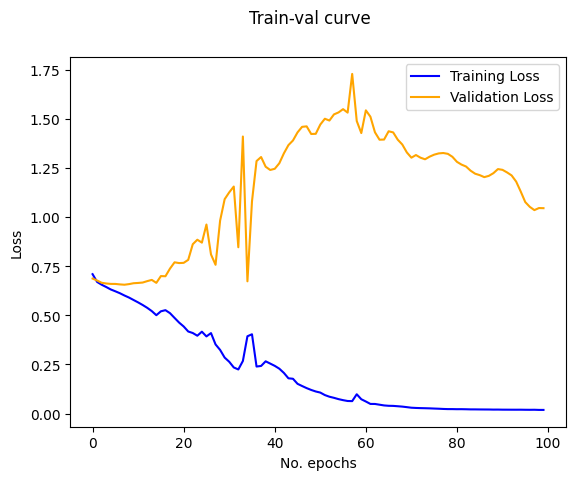

0.5


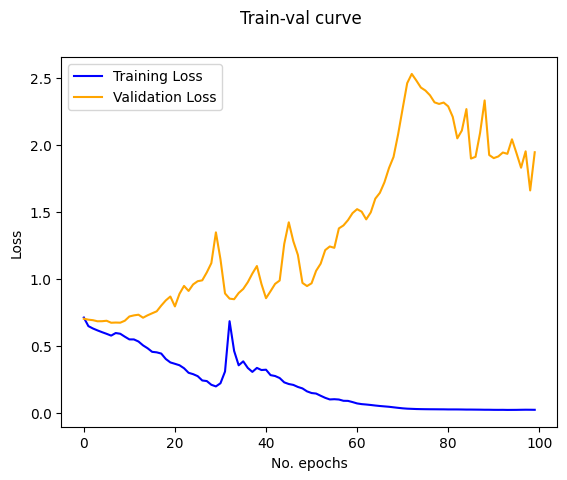

0.375


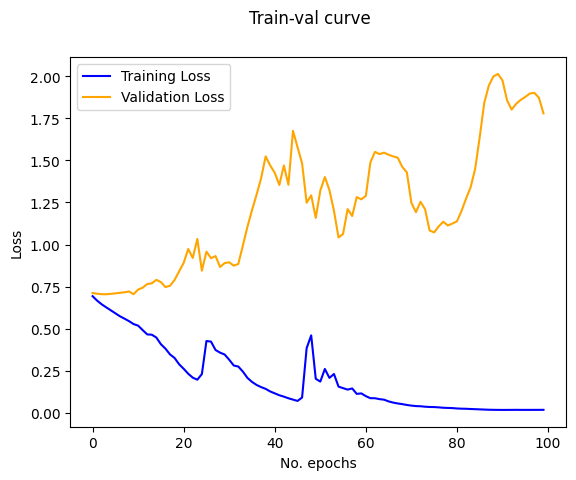

0.875


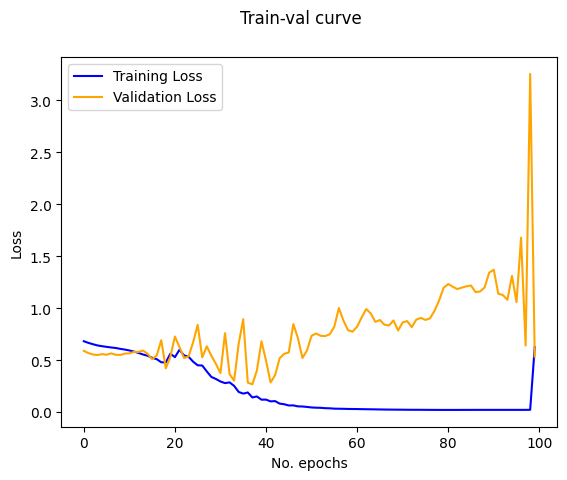

0.8571428571428571


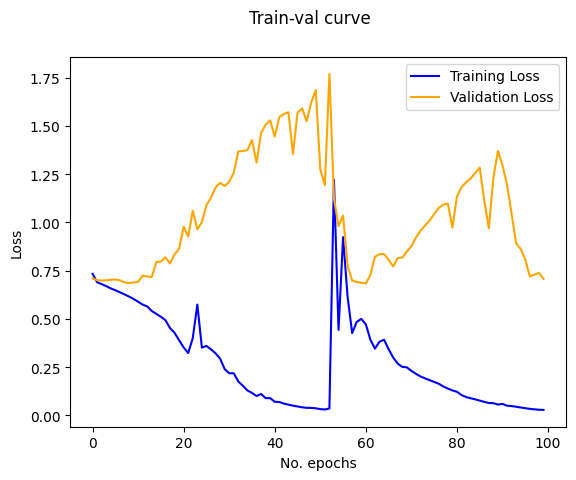

In [37]:
def plot_train_val_curve(train_loss:list, val_loss:list) -> None:
    '''function for plotting train-val curve while trianing neural network
    Args:
        train_loss - list with losses obtained during training
        val_loss - list with losses obtained during validation
    Out:
        None
    '''
    #assert same length
    assert len(train_loss)==len(val_loss)
    epoch_list = [i for i in range(len(train_loss))]
    
    #plot
    plt.plot(epoch_list, train_loss, 'blue', label='Training Loss')
    plt.plot(epoch_list, val_loss, 'orange', label='Validation Loss')
    plt.xlabel('No. epochs')
    plt.ylabel('Loss')
    plt.suptitle('Train-val curve')
    plt.legend()
    plt.show()
    
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

We can clearly see that we get nice loss function for train curve but our validation curve is very unstable. This means two things:
* good thing is that our model is consistently able to learn from the data and make predictions based on our features (if our features were 'random' or badly engineered, the training loss wouldn decrease so nicely
* bad thing is that it is not generalizing well i.e. its overfitting as the validation curve is a bit crazy. This is to be expected with so many features and more feature engineering would be required to get an optimal number of features while keeping all useful information. As I don't have enough time to explore all feature engineering options, I will instead aim to improve the model performance as it is now through some changes to the architecture & training environment

I will add dropout to hopefully reduce the overfitting. I can also play with the learning rate & number of epochs to see which is the most optimal one. Increasing the learning rate might be a good first step.

In [40]:
# Define modified LSTM model
class LSTMModel_general(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_general, self).__init__()
        self.hidden_size = hidden_size #required for RNN to keep 'memory'
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() #required for binary classification
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # initialize randomly
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.dropout(out)
        out = out[:, -1, :]
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out
        
#need to redefine the functions now that we have new model
def run_training(model:nn.Module, data:torch.Tensor, targets:pd.Series, train_ids:list, val_ids:list, log_dict:dict, i:int, epochs:int, lr:int) -> int:
    '''function for training the network using CV
    Args:
        model - instantiated model, LSTM 
        data - data used for modelling 
        targets - targets to be predicted
        train_ids - list of home ids used for training in this fold
        val_ids - list of home ids used for validation in this fold
        log_dict - dictionary for logging the performance of the model during training
        i - integer indicating fold number
        epochs  - (optional) no of epochs used for trianing
        lr  - (optional) learning rate
    Output
        integer, accuracy score for this training 
    '''
    # instantiate loss function, set up variables
    criterion = nn.BCELoss()
    best_val_loss = float('inf') #set it up 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay =0.01)
    num_epochs = epochs
    
    #training 
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for mode in ['train','val']:
            targets = torch.tensor(targets, dtype=torch.float32)
            if mode=='train':
                model.train()
                optimizer.zero_grad()
                outputs = model(data[train_ids])
                loss = criterion(outputs.squeeze(), targets[train_ids])
                print('train loss:',loss.item())
                loss.backward()
                optimizer.step()
                log_dict['train'].append(loss.item())
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model(data[val_ids])
                    loss = criterion(outputs.squeeze(), targets[val_ids])
                    print('val loss:',loss.item())

                #save model which achieved best validation
                if loss.item() < best_val_loss:
                    print('best model so far, saving')
                    torch.save(model.state_dict(), f'results/best_model_cv{i}.pth')
                    best_val_loss = loss.item()
                log_dict['val'].append(loss.item())
                
    #save final model
    print('training finished, saving final model')
    torch.save(model.state_dict(), f'results/final_model_cv{i}.pth')
    return metrics.accuracy_score(targets[val_ids], outputs.squeeze().round())

def run_cv_training(data:torch.tensor, targets:pd.Series, n_epochs:int=100, learning_r:int=0.01) -> tuple:
    '''function for running 5 fold cross validation when trianing the neural network
    Args:
       data - torch.tensor data used for modelling
       targets - targets to be predicted
       n_epochs  - (optional) no of epochs used for trianing
       learning_r  - (optional) learning rate
    Output
       fold_loss - log dictionary showing val and train loss functions obtained during training
       fold_performance - log dictionary showing performance for each fold
    '''
    #instantiate kfold, log_dictionaries
    kfold = KFold(5, shuffle=True, random_state=38)
    fold_loss={}
    fold_performance={}
    start = time.time()

    #set up variables
    input_size = data.shape[2]  
    hidden_size = 8
    num_layers = 1
    output_size = 1 
    
    #start cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train)):
        print(fold)
        fold_loss[fold]={'train':[], 'val':[]}
        
        # instantiate new model for each fold
        model = LSTMModel_general(input_size, hidden_size, num_layers, output_size)
    
        #train
        fold_performance[fold]=run_training(model, data, targets, train_ids, val_ids, fold_loss[fold], fold, epochs=100, lr=learning_r)
                        
    end=time.time()
    print('Total inference time for CV training (in second): ', end-start)
    return fold_loss, fold_performance



In [41]:
fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train, learning_r=0.001)

0
Epoch [1/100]
train loss: 0.6997602581977844
val loss: 0.6794139742851257
best model so far, saving
Epoch [2/100]
train loss: 0.6970036625862122


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6798373460769653
Epoch [3/100]
train loss: 0.6879586577415466
val loss: 0.6798697710037231
Epoch [4/100]
train loss: 0.6876944303512573
val loss: 0.6797095537185669
Epoch [5/100]
train loss: 0.68448406457901
val loss: 0.6794066429138184
best model so far, saving
Epoch [6/100]
train loss: 0.6862621307373047
val loss: 0.6790105104446411
best model so far, saving
Epoch [7/100]
train loss: 0.6811712384223938
val loss: 0.6785147190093994
best model so far, saving
Epoch [8/100]
train loss: 0.682214617729187
val loss: 0.6779580116271973
best model so far, saving
Epoch [9/100]
train loss: 0.6752150654792786
val loss: 0.6773138046264648
best model so far, saving
Epoch [10/100]
train loss: 0.6826508641242981
val loss: 0.6767554879188538
best model so far, saving
Epoch [11/100]
train loss: 0.6825900673866272
val loss: 0.6764264106750488
best model so far, saving
Epoch [12/100]
train loss: 0.6725035905838013
val loss: 0.676182210445404
best model so far, saving
Epoch [13/100]
train los

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.7114449143409729
best model so far, saving
Epoch [3/100]
train loss: 0.7117850184440613
val loss: 0.7105135321617126
best model so far, saving
Epoch [4/100]
train loss: 0.7087553143501282
val loss: 0.7097623944282532
best model so far, saving
Epoch [5/100]
train loss: 0.7094760537147522
val loss: 0.7092204093933105
best model so far, saving
Epoch [6/100]
train loss: 0.7041925191879272
val loss: 0.7087905406951904
best model so far, saving
Epoch [7/100]
train loss: 0.6990595459938049
val loss: 0.7084745168685913
best model so far, saving
Epoch [8/100]
train loss: 0.7076841592788696
val loss: 0.7083089351654053
best model so far, saving
Epoch [9/100]
train loss: 0.6932911276817322
val loss: 0.7082006931304932
best model so far, saving
Epoch [10/100]
train loss: 0.6988574862480164
val loss: 0.7081729173660278
best model so far, saving
Epoch [11/100]
train loss: 0.6987800598144531
val loss: 0.7080970406532288
best model so far, saving
Epoch [12/100]
train loss: 0.68651306629180

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6766703128814697
val loss: 0.671823263168335
best model so far, saving
Epoch [2/100]
train loss: 0.6772082448005676
val loss: 0.67229163646698
Epoch [3/100]
train loss: 0.6672602295875549
val loss: 0.6724790930747986
Epoch [4/100]
train loss: 0.6709991693496704
val loss: 0.6725342869758606
Epoch [5/100]
train loss: 0.6711958050727844
val loss: 0.6725296378135681
Epoch [6/100]
train loss: 0.6656877398490906
val loss: 0.672477662563324
Epoch [7/100]
train loss: 0.6595382690429688
val loss: 0.6723893880844116
Epoch [8/100]
train loss: 0.6671478748321533
val loss: 0.6722597479820251
Epoch [9/100]
train loss: 0.6664303541183472
val loss: 0.6720681190490723
Epoch [10/100]
train loss: 0.659768283367157
val loss: 0.6718625426292419
Epoch [11/100]
train loss: 0.6580233573913574
val loss: 0.6716890931129456
best model so far, saving
Epoch [12/100]
train loss: 0.6631749868392944
val loss: 0.6715750098228455
best model so far, saving
Epoch [13/100]
train loss: 0.6584976315498352
val 

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6958737373352051
best model so far, saving
Epoch [3/100]
train loss: 0.7000442743301392
val loss: 0.69419264793396
best model so far, saving
Epoch [4/100]
train loss: 0.6897303462028503
val loss: 0.6925137042999268
best model so far, saving
Epoch [5/100]
train loss: 0.6988879442214966
val loss: 0.6910485029220581
best model so far, saving
Epoch [6/100]
train loss: 0.6970443725585938
val loss: 0.6897199153900146
best model so far, saving
Epoch [7/100]
train loss: 0.7019561529159546
val loss: 0.6884875893592834
best model so far, saving
Epoch [8/100]
train loss: 0.687789261341095
val loss: 0.6869767904281616
best model so far, saving
Epoch [9/100]
train loss: 0.6987748146057129
val loss: 0.6854725480079651
best model so far, saving
Epoch [10/100]
train loss: 0.6991226673126221
val loss: 0.684009850025177
best model so far, saving
Epoch [11/100]
train loss: 0.6993868350982666
val loss: 0.6827380061149597
best model so far, saving
Epoch [12/100]
train loss: 0.6955000162124634
v

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.702839195728302
Epoch [3/100]
train loss: 0.6706262826919556
val loss: 0.702859103679657
Epoch [4/100]
train loss: 0.6628116369247437
val loss: 0.7029383778572083
Epoch [5/100]
train loss: 0.6607007384300232
val loss: 0.7031981348991394
Epoch [6/100]
train loss: 0.6540669202804565
val loss: 0.7040702700614929
Epoch [7/100]
train loss: 0.6488958597183228
val loss: 0.705387532711029
Epoch [8/100]
train loss: 0.6456838846206665
val loss: 0.706960141658783
Epoch [9/100]
train loss: 0.6452435851097107
val loss: 0.7082770466804504
Epoch [10/100]
train loss: 0.6485534906387329
val loss: 0.7091118693351746
Epoch [11/100]
train loss: 0.6483602523803711
val loss: 0.7096051573753357
Epoch [12/100]
train loss: 0.6438049077987671
val loss: 0.7098664045333862
Epoch [13/100]
train loss: 0.6427170038223267
val loss: 0.7099890112876892
Epoch [14/100]
train loss: 0.6394655108451843
val loss: 0.7099229097366333
Epoch [15/100]
train loss: 0.6395666003227234
val loss: 0.7096861004829407
Epoch [

0.5


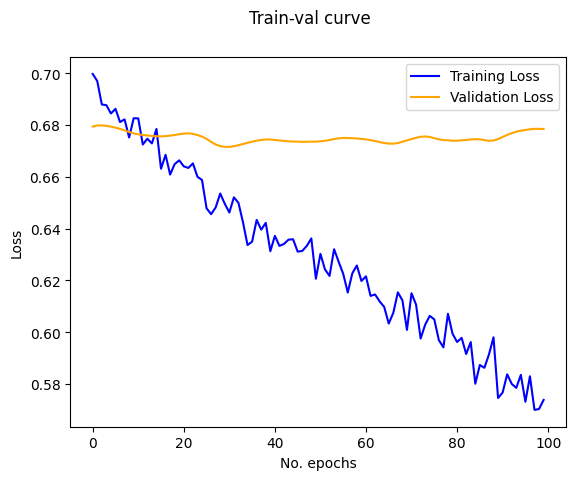

0.375


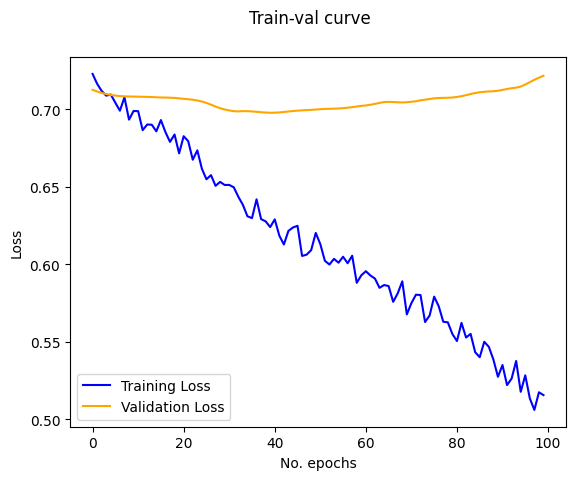

0.625


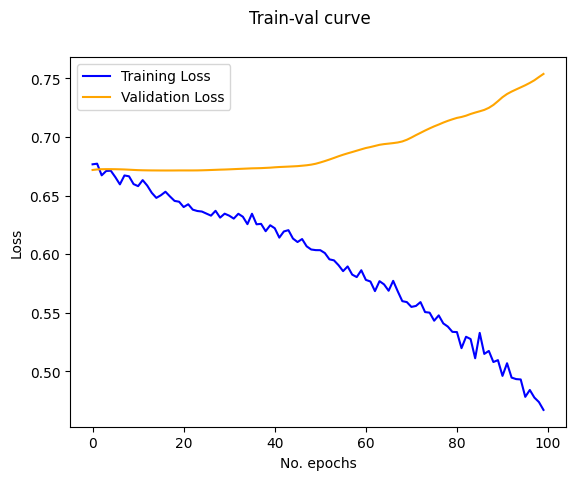

0.875


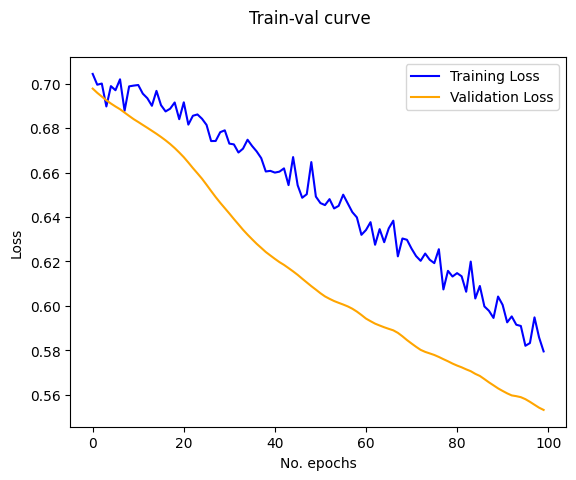

0.42857142857142855


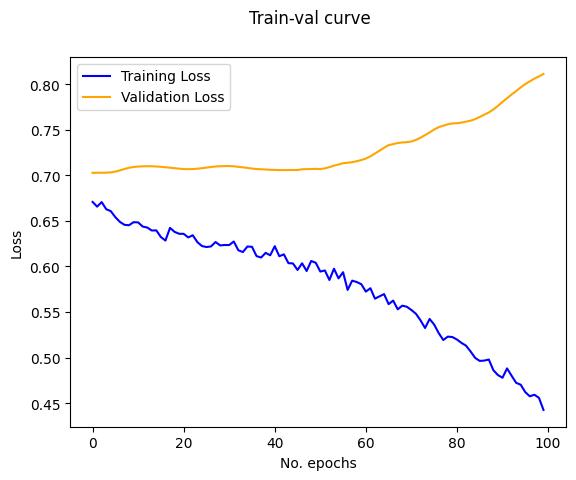

In [42]:
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

Decreasing the learning rate hasnt improved the results but made training more consistent; lets try increasing

In [43]:
fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train, n_epochs=100, learning_r=0.1)

0
Epoch [1/100]
train loss: 0.6980852484703064
val loss: 0.7021122574806213
best model so far, saving
Epoch [2/100]


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6620413064956665
val loss: 0.7162233591079712
Epoch [3/100]
train loss: 0.6192870140075684
val loss: 0.7711388468742371
Epoch [4/100]
train loss: 0.6047026515007019
val loss: 0.7664376497268677
Epoch [5/100]
train loss: 0.5737552046775818
val loss: 0.748131513595581
Epoch [6/100]
train loss: 0.600024938583374
val loss: 0.8113048672676086
Epoch [7/100]
train loss: 0.6138820648193359
val loss: 0.7991677522659302
Epoch [8/100]
train loss: 0.5868003964424133
val loss: 0.8015850186347961
Epoch [9/100]
train loss: 0.5694864392280579
val loss: 0.7993246912956238
Epoch [10/100]
train loss: 0.5441696643829346
val loss: 0.7866784334182739
Epoch [11/100]
train loss: 0.6033106446266174
val loss: 0.8183035850524902
Epoch [12/100]
train loss: 0.6188291311264038
val loss: 0.7773755788803101
Epoch [13/100]
train loss: 0.5944422483444214
val loss: 0.7332634925842285
Epoch [14/100]
train loss: 0.5998049974441528
val loss: 0.7799515724182129
Epoch [15/100]
train loss: 0.6395569443702698
val

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6052241921424866
val loss: 0.6489695310592651
best model so far, saving
Epoch [4/100]
train loss: 0.6340222954750061
val loss: 0.6753141283988953
Epoch [5/100]
train loss: 0.5928078293800354
val loss: 0.6634786128997803
Epoch [6/100]
train loss: 0.6095531582832336
val loss: 0.6485130786895752
best model so far, saving
Epoch [7/100]
train loss: 0.585610568523407
val loss: 0.6236810088157654
best model so far, saving
Epoch [8/100]
train loss: 0.5830929279327393
val loss: 0.6458476781845093
Epoch [9/100]
train loss: 0.5702094435691833
val loss: 0.6670457720756531
Epoch [10/100]
train loss: 0.5689259171485901
val loss: 0.6432344913482666
Epoch [11/100]
train loss: 0.5857690572738647
val loss: 0.6164679527282715
best model so far, saving
Epoch [12/100]
train loss: 0.5699177980422974
val loss: 0.6152340173721313
best model so far, saving
Epoch [13/100]
train loss: 0.5555483102798462
val loss: 0.657672107219696
Epoch [14/100]
train loss: 0.6050609350204468
val loss: 0.6699151992

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.781408429145813
val loss: 0.713505744934082
best model so far, saving
Epoch [2/100]
train loss: 0.7088611721992493
val loss: 0.694669246673584
best model so far, saving
Epoch [3/100]
train loss: 0.7017853260040283
val loss: 0.6891419291496277
best model so far, saving
Epoch [4/100]
train loss: 0.6169843077659607
val loss: 0.7065542936325073
Epoch [5/100]
train loss: 0.6165418028831482
val loss: 0.7182491421699524
Epoch [6/100]
train loss: 0.5971004962921143
val loss: 0.7049167156219482
Epoch [7/100]
train loss: 0.6010172367095947
val loss: 0.7473029494285583
Epoch [8/100]
train loss: 0.5644959807395935
val loss: 0.7720897197723389
Epoch [9/100]
train loss: 0.5585559606552124
val loss: 0.7532846927642822
Epoch [10/100]
train loss: 0.5709022283554077
val loss: 0.8060398101806641
Epoch [11/100]
train loss: 0.5442159175872803
val loss: 0.8511030077934265
Epoch [12/100]
train loss: 0.5424945950508118
val loss: 0.866278350353241
Epoch [13/100]
train loss: 0.5400053858757019
val

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.4776665270328522
best model so far, saving
Epoch [3/100]
train loss: 0.6593241691589355
val loss: 0.5621578097343445
Epoch [4/100]
train loss: 0.6462721228599548
val loss: 0.6455035209655762
Epoch [5/100]
train loss: 0.6512517333030701
val loss: 0.6343122124671936
Epoch [6/100]
train loss: 0.6130222082138062
val loss: 0.7412301898002625
Epoch [7/100]
train loss: 0.5924312472343445
val loss: 0.7715842127799988
Epoch [8/100]
train loss: 0.567743718624115
val loss: 0.4772084951400757
best model so far, saving
Epoch [9/100]
train loss: 0.5586352348327637
val loss: 0.4397946894168854
best model so far, saving
Epoch [10/100]
train loss: 0.6704930663108826
val loss: 0.8706178665161133
Epoch [11/100]
train loss: 0.7075701355934143
val loss: 0.7196691036224365
Epoch [12/100]
train loss: 0.6771976351737976
val loss: 0.6380571126937866
Epoch [13/100]
train loss: 0.6082342863082886
val loss: 0.49705928564071655
Epoch [14/100]
train loss: 0.6262953877449036
val loss: 0.5525986552238464


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_21968\1624408015.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6674719452857971
best model so far, saving
Epoch [3/100]
train loss: 0.6566330790519714
val loss: 0.6454641222953796
best model so far, saving
Epoch [4/100]
train loss: 0.6406416893005371
val loss: 0.6644471883773804
Epoch [5/100]
train loss: 0.6164073944091797
val loss: 0.6768245697021484
Epoch [6/100]
train loss: 0.6250444054603577
val loss: 0.6867374181747437
Epoch [7/100]
train loss: 0.5727267265319824
val loss: 0.644302487373352
best model so far, saving
Epoch [8/100]
train loss: 0.6180902123451233
val loss: 0.66277676820755
Epoch [9/100]
train loss: 0.5764540433883667
val loss: 0.7849745154380798
Epoch [10/100]
train loss: 0.6514663100242615
val loss: 0.6255318522453308
best model so far, saving
Epoch [11/100]
train loss: 0.5910043716430664
val loss: 0.5885990858078003
best model so far, saving
Epoch [12/100]
train loss: 0.6219526529312134
val loss: 0.5738802552223206
best model so far, saving
Epoch [13/100]
train loss: 0.6094288229942322
val loss: 0.5672302842140198


0.5


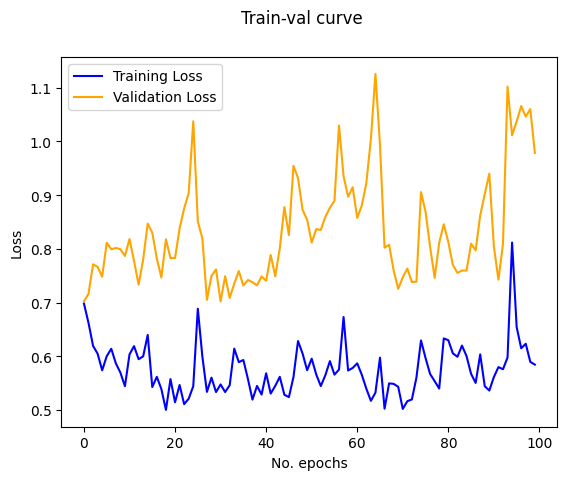

0.625


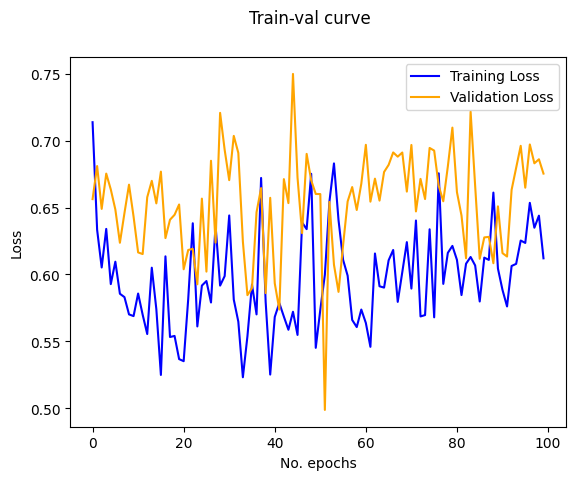

0.625


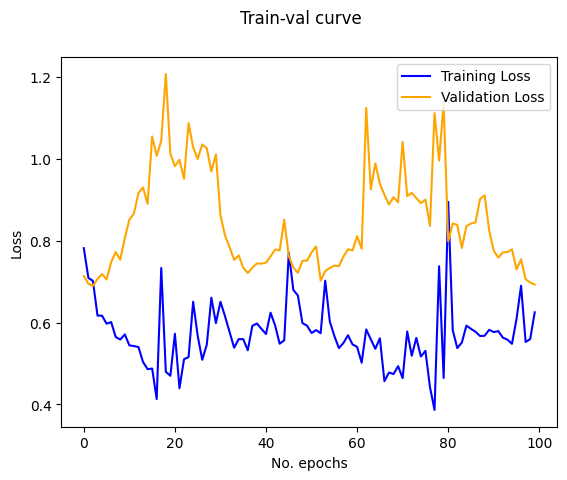

0.875


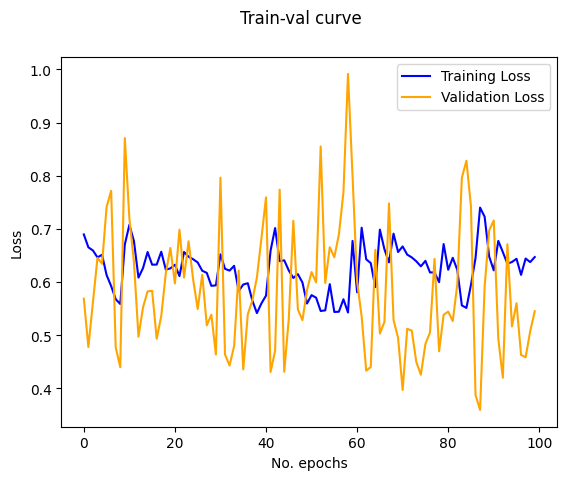

0.2857142857142857


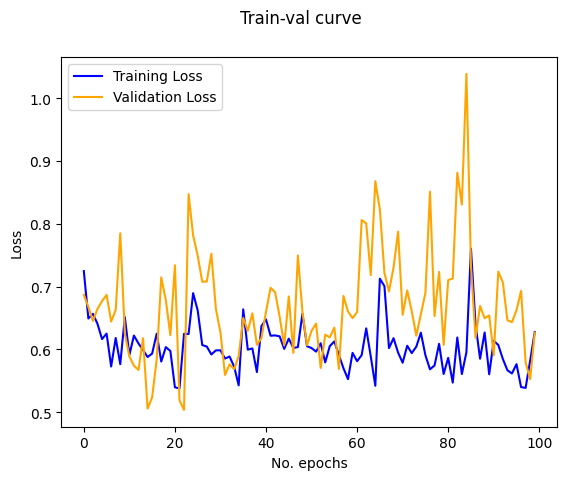

In [44]:
#plot  
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

The training and val curves are much less stable (to be expected with overshooting lr) but performance overall seems better; we could do that for a while so instead I will now examine the performance of the model on the test set 

### Testing

In [45]:
#load state_dict
state_dict = torch.load('results/best_model_cv3.pth') #possible best cv model based on the plots
model = LSTMModel_general(26472, 8, 1, 1)
model.load_state_dict(state_dict)

#test performance
start = time.time()
model.eval()
result = []
for i in range(len(X_test)):
    output =model(torch.tensor(np.array(X_test))[i].unsqueeze(0))
    result.append(output.round().detach().cpu().numpy())
end = time.time()

print('Total inference time for entire test set (in second): ', end-start)
result = [i[0][0] for i in result]

Total inference time for entire test set (in second):  0.15570759773254395


In [44]:
print(metrics.confusion_matrix(y_test, result))
print(metrics.accuracy_score(y_test, result))


[[1 3]
 [0 7]]
0.7272727272727273


The model performs with 73% accuracy and has relatively quick training & inference time

## Final remarks

Due to time constraints I wont have time to export & validate the model into onnx format; while it's definitely beneficial from deployment perspective, for the purpose of this task I will skip it.

If I had more time, I would have done the following: 
* explore finetuning of the hyperparameters (eg can use RayTune instead of manual changes)
* explore the feature importance during the cross validation to confirm generelizability(can use SHAP)
* explore other feature engineering approaches and see which works best (and how to reduce the high dimensionality of features)
* try more models & benchmark 
* write some unit tests to ensure code's reliability (normally would be done in parallel to coding but couldn't do it this time due to time constraints)
* test the model with unseen data (if available)
* divide the notebook into documented scripts according to good software development practice - my preferred way of working is also within scripts and I am not very used to notebooks but for the sake of this excercise I used the notebooks